<a href="https://colab.research.google.com/github/HimalKarkal/netball-analysis/blob/master/Player_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classify players into positions based on time spent at each

In [16]:
# Installing GitHub repository and other packages

! git clone 'https://github.com/HimalKarkal/netball-analysis.git'

import numpy as np
import pandas as pd
import glob

fatal: destination path 'netball-analysis' already exists and is not an empty directory.


In [17]:
# Creating a list of filepaths

paths = glob.glob('/content/netball-analysis/data/matchCentre/processed/*/*substitutions_202*_SSN_*.csv')
paths.sort()

In [18]:
# Creating empty dictionaries:

masterdict = {'GS':{},
'GA':{},
'WA': {},
'C': {},
'WD': {},
'GD': {},
'GK': {},
'S': {}}

for file in paths:
  df = pd.read_csv(file)

  for i, row in df.iterrows():
    player = row['playerId']
    position = row['startingPos']
    duration = np.round((row['duration']/3600),2) #Converting seconds to hours

    if position in masterdict:
      if player in masterdict[position]:
        masterdict[position][player] += duration
      else:
        masterdict[position][player] = duration

df_final = pd.DataFrame(masterdict).fillna(0).reset_index()
df_final = df_final.rename(columns={'index': 'playerId'})
df_final.head()

,playerId,GS,GA,WA,C,WD,GD,GK,S
0,80078,40.88,0.00,0.0,0.0,0.0,0.0,0.0,4.42
1,1009721,0.33,0.67,0.0,0.0,0.0,0.0,0.0,13.02
2,1001357,42.90,10.28,0.0,0.0,0.0,0.0,0.0,5.00
3,1014128,7.36,0.00,0.0,0.0,0.0,0.0,0.0,23.81
4,1001865,35.44,0.00,0.0,0.0,0.0,0.0,0.0,4.56


In [70]:
df_final_fractional = df_final.copy()

In [71]:
df_final_fractional['sum'] = df_final_fractional[['GS', 'GA', 'WA', 'C', 'WD', 'GD', 'GK']].sum(axis = 1)

In [72]:
df_final_fractional[['GS', 'GA', 'WA', 'C', 'WD', 'GD', 'GK']] = df_final_fractional[['GS', 'GA', 'WA', 'C', 'WD', 'GD', 'GK']].div(df_final_fractional['sum'], axis = 0)

In [73]:
df_final_fractional = df_final_fractional.dropna()

In [74]:
df_final_fractional.head()

,playerId,GS,GA,WA,C,WD,GD,GK,S,sum
0,80078,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,4.42,40.88
1,1009721,0.330000,0.670000,0.0,0.0,0.0,0.0,0.0,13.02,1.00
2,1001357,0.806694,0.193306,0.0,0.0,0.0,0.0,0.0,5.00,53.18
3,1014128,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,23.81,7.36
4,1001865,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,4.56,35.44


In [75]:
df_final_fractional = df_final_fractional.drop(columns = ['S','sum'])

In [76]:
df_final_fractional.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151 entries, 0 to 150
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   playerId  151 non-null    int64  
 1   GS        151 non-null    float64
 2   GA        151 non-null    float64
 3   WA        151 non-null    float64
 4   C         151 non-null    float64
 5   WD        151 non-null    float64
 6   GD        151 non-null    float64
 7   GK        151 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 10.6 KB


# K-Means clustering

In [77]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [78]:
def optimise_k_means(data, max_k):
  means = []
  inertias = []
  for k in range(1, max_k):
    kmeans = KMeans(n_clusters = k, n_init = 10).fit(data)
    means.append(k)
    inertias.append(kmeans.inertia_)

  plt.plot(means, inertias, '-o')
  plt.title(f'Elbow Method for {len(data.columns)} features using KMeans clustering')
  plt.xlabel('Number of clusters')
  plt.ylabel('Inertia')
  plt.grid(True)
  plt.show()

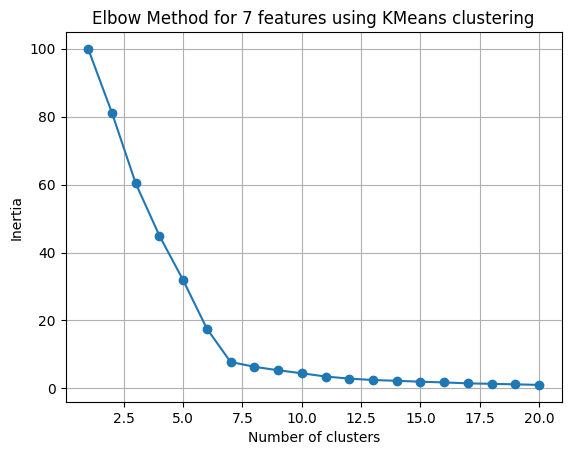

In [79]:
optimise_k_means(df_final_fractional.iloc[:,1:], 21)

In [80]:
# Applying KMeans clustring to data with number of clusters == 10

kmeans = KMeans(n_clusters = 7, n_init =10).fit(df_final_fractional.iloc[:,1:])

df_final_fractional['kmeans'] = kmeans.labels_
df_final_fractional.head()

,playerId,GS,GA,WA,C,WD,GD,GK,kmeans
0,80078,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,4
1,1009721,0.330000,0.670000,0.0,0.0,0.0,0.0,0.0,2
2,1001357,0.806694,0.193306,0.0,0.0,0.0,0.0,0.0,4
3,1014128,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,4
4,1001865,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,4


In [81]:
# Visualising using a plotly parallel coordinates plot

import plotly.express as px

fig = px.parallel_coordinates(df_final_fractional.drop(columns = 'playerId'), color='kmeans')
fig.write_html("parallel coordinates plot.html")
fig.show()